# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

mkdir: cannot create directory â€˜resultsâ€™: File exists


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [ ]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        std = torch.exp(0.5*log_variances)
        eps = torch.randn_like(std)
        return means + eps*std

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        means, log_variances = self.encode(x.view(-1, 784))
        z = self.reparameterize(means, log_variances)
        return self.decode(z), means, log_variances

# Loss Functions

In [ ]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())

    return BCE + KLD, BCE

# Training

In [ ]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    train_loss = 0
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, BCE = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        train_BCE += BCE.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_loss = train_loss / len(train_loader.dataset)
    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average train loss: {:.4f}'.format(epoch, average_train_loss))
    print('====> Epoch: {} Average BCE loss: {:.4f}'.format(epoch, average_train_BCE))
    return average_train_loss, average_train_BCE



# Testing

In [ ]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    test_loss = 0
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, BCE = vae_loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            test_BCE += BCE.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_loss = test_loss / len(test_loader.dataset)
    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_loss))
    print('====> Test set BCE: {:.4f}'.format(average_test_BCE))
    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.461975
Train Epoch: 1 [12800/60000 (21%)]	Loss: 152.303558
Train Epoch: 1 [25600/60000 (43%)]	Loss: 115.208435
Train Epoch: 1 [38400/60000 (64%)]	Loss: 103.194580
Train Epoch: 1 [51200/60000 (85%)]	Loss: 92.418785
====> Epoch: 1 Average loss: 130.1939
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


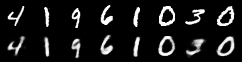

====> Test set loss: 87.8944
Sample of generated images


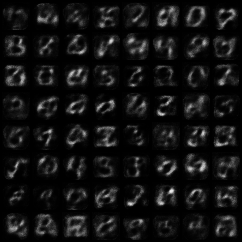



Train Epoch: 2 [0/60000 (0%)]	Loss: 92.931625
Train Epoch: 2 [12800/60000 (21%)]	Loss: 83.931427
Train Epoch: 2 [25600/60000 (43%)]	Loss: 86.029442
Train Epoch: 2 [38400/60000 (64%)]	Loss: 80.006424
Train Epoch: 2 [51200/60000 (85%)]	Loss: 81.750328
====> Epoch: 2 Average loss: 82.5670
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


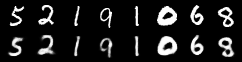

====> Test set loss: 77.6694
Sample of generated images


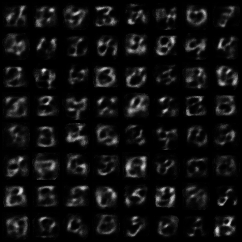



Train Epoch: 3 [0/60000 (0%)]	Loss: 75.964928
Train Epoch: 3 [12800/60000 (21%)]	Loss: 78.513588
Train Epoch: 3 [25600/60000 (43%)]	Loss: 75.922897
Train Epoch: 3 [38400/60000 (64%)]	Loss: 79.353546
Train Epoch: 3 [51200/60000 (85%)]	Loss: 74.809586
====> Epoch: 3 Average loss: 76.8031
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


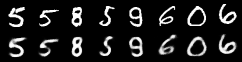

====> Test set loss: 74.5040
Sample of generated images


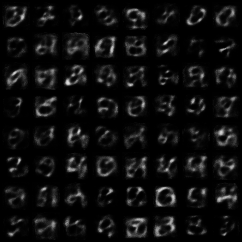



Train Epoch: 4 [0/60000 (0%)]	Loss: 76.431389
Train Epoch: 4 [12800/60000 (21%)]	Loss: 76.556320
Train Epoch: 4 [25600/60000 (43%)]	Loss: 73.193893
Train Epoch: 4 [38400/60000 (64%)]	Loss: 70.500626
Train Epoch: 4 [51200/60000 (85%)]	Loss: 71.979362
====> Epoch: 4 Average loss: 74.0850
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


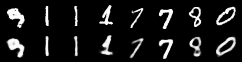

====> Test set loss: 72.5014
Sample of generated images


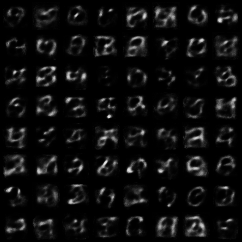



Train Epoch: 5 [0/60000 (0%)]	Loss: 72.257019
Train Epoch: 5 [12800/60000 (21%)]	Loss: 72.066124
Train Epoch: 5 [25600/60000 (43%)]	Loss: 73.690445
Train Epoch: 5 [38400/60000 (64%)]	Loss: 72.247223
Train Epoch: 5 [51200/60000 (85%)]	Loss: 70.573105
====> Epoch: 5 Average loss: 72.3123
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


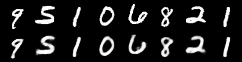

====> Test set loss: 71.2188
Sample of generated images


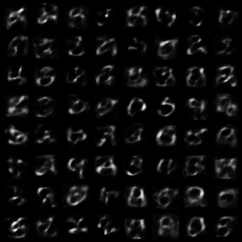



Train Epoch: 6 [0/60000 (0%)]	Loss: 74.204010
Train Epoch: 6 [12800/60000 (21%)]	Loss: 69.970673
Train Epoch: 6 [25600/60000 (43%)]	Loss: 73.854477
Train Epoch: 6 [38400/60000 (64%)]	Loss: 70.650848
Train Epoch: 6 [51200/60000 (85%)]	Loss: 71.182983
====> Epoch: 6 Average loss: 71.0556
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


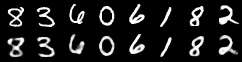

====> Test set loss: 70.2309
Sample of generated images


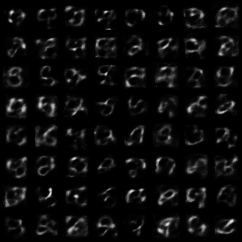



Train Epoch: 7 [0/60000 (0%)]	Loss: 69.413010
Train Epoch: 7 [12800/60000 (21%)]	Loss: 71.991142
Train Epoch: 7 [25600/60000 (43%)]	Loss: 70.625130
Train Epoch: 7 [38400/60000 (64%)]	Loss: 71.708221
Train Epoch: 7 [51200/60000 (85%)]	Loss: 69.111053
====> Epoch: 7 Average loss: 70.0943
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


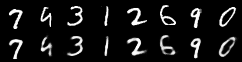

====> Test set loss: 69.4898
Sample of generated images


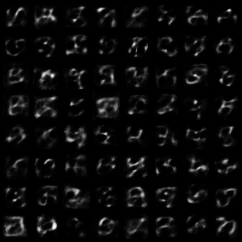



Train Epoch: 8 [0/60000 (0%)]	Loss: 70.319069
Train Epoch: 8 [12800/60000 (21%)]	Loss: 68.247650
Train Epoch: 8 [25600/60000 (43%)]	Loss: 67.515732
Train Epoch: 8 [38400/60000 (64%)]	Loss: 67.543640
Train Epoch: 8 [51200/60000 (85%)]	Loss: 70.146606
====> Epoch: 8 Average loss: 69.3482
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


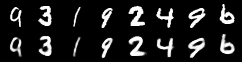

====> Test set loss: 68.7960
Sample of generated images


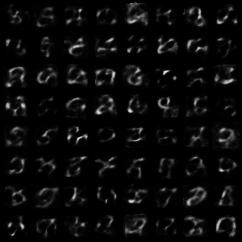



Train Epoch: 9 [0/60000 (0%)]	Loss: 70.115555
Train Epoch: 9 [12800/60000 (21%)]	Loss: 68.813217
Train Epoch: 9 [25600/60000 (43%)]	Loss: 70.691025
Train Epoch: 9 [38400/60000 (64%)]	Loss: 68.197510
Train Epoch: 9 [51200/60000 (85%)]	Loss: 70.721977
====> Epoch: 9 Average loss: 68.7342
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


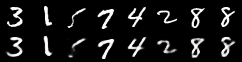

====> Test set loss: 68.4205
Sample of generated images


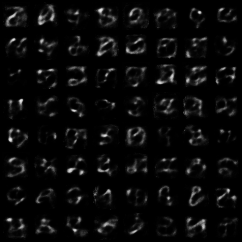



Train Epoch: 10 [0/60000 (0%)]	Loss: 66.470978
Train Epoch: 10 [12800/60000 (21%)]	Loss: 66.922150
Train Epoch: 10 [25600/60000 (43%)]	Loss: 66.884750
Train Epoch: 10 [38400/60000 (64%)]	Loss: 65.233124
Train Epoch: 10 [51200/60000 (85%)]	Loss: 70.212601
====> Epoch: 10 Average loss: 68.2227
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


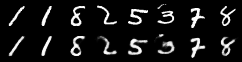

====> Test set loss: 67.9496
Sample of generated images


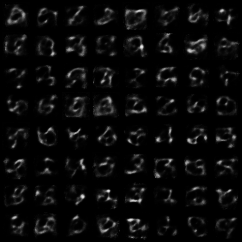



Train Epoch: 1 [0/60000 (0%)]	Loss: 550.994385
Train Epoch: 1 [12800/60000 (21%)]	Loss: 184.824951
Train Epoch: 1 [25600/60000 (43%)]	Loss: 159.566208
Train Epoch: 1 [38400/60000 (64%)]	Loss: 144.254852
Train Epoch: 1 [51200/60000 (85%)]	Loss: 124.650269
====> Epoch: 1 Average train loss: 163.2656
====> Epoch: 1 Average BCE loss: 147.4790
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


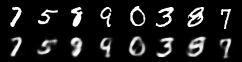

====> Test set loss: 126.6483
====> Test set BCE: 106.1798
Sample of generated images


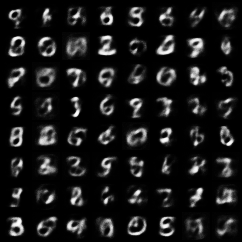



Train Epoch: 2 [0/60000 (0%)]	Loss: 130.446533
Train Epoch: 2 [12800/60000 (21%)]	Loss: 120.285713
Train Epoch: 2 [25600/60000 (43%)]	Loss: 120.272873
Train Epoch: 2 [38400/60000 (64%)]	Loss: 116.616470
Train Epoch: 2 [51200/60000 (85%)]	Loss: 116.878494
====> Epoch: 2 Average train loss: 121.0178
====> Epoch: 2 Average BCE loss: 98.9445
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


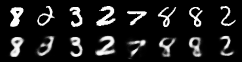

====> Test set loss: 115.4855
====> Test set BCE: 92.2146
Sample of generated images


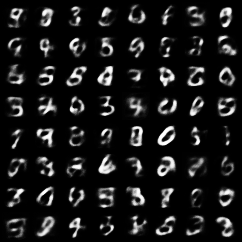



Train Epoch: 3 [0/60000 (0%)]	Loss: 114.076347
Train Epoch: 3 [12800/60000 (21%)]	Loss: 116.057076
Train Epoch: 3 [25600/60000 (43%)]	Loss: 118.338676
Train Epoch: 3 [38400/60000 (64%)]	Loss: 117.438095
Train Epoch: 3 [51200/60000 (85%)]	Loss: 114.679962
====> Epoch: 3 Average train loss: 114.4396
====> Epoch: 3 Average BCE loss: 90.7641
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


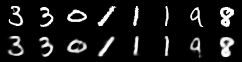

====> Test set loss: 111.5412
====> Test set BCE: 87.0362
Sample of generated images


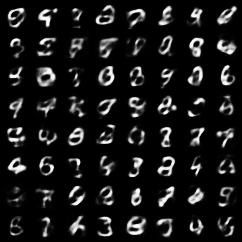



Train Epoch: 4 [0/60000 (0%)]	Loss: 114.788971
Train Epoch: 4 [12800/60000 (21%)]	Loss: 111.401894
Train Epoch: 4 [25600/60000 (43%)]	Loss: 111.651031
Train Epoch: 4 [38400/60000 (64%)]	Loss: 108.996521
Train Epoch: 4 [51200/60000 (85%)]	Loss: 113.681847
====> Epoch: 4 Average train loss: 111.3731
====> Epoch: 4 Average BCE loss: 86.9527
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


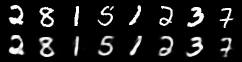

====> Test set loss: 109.3705
====> Test set BCE: 84.9821
Sample of generated images


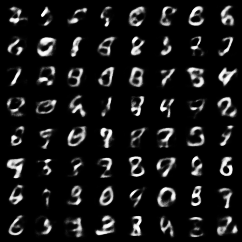



Train Epoch: 5 [0/60000 (0%)]	Loss: 113.797478
Train Epoch: 5 [12800/60000 (21%)]	Loss: 111.025398
Train Epoch: 5 [25600/60000 (43%)]	Loss: 113.010178
Train Epoch: 5 [38400/60000 (64%)]	Loss: 110.000282
Train Epoch: 5 [51200/60000 (85%)]	Loss: 106.805031
====> Epoch: 5 Average train loss: 109.6671
====> Epoch: 5 Average BCE loss: 84.9519
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


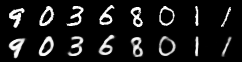

====> Test set loss: 108.3410
====> Test set BCE: 83.0081
Sample of generated images


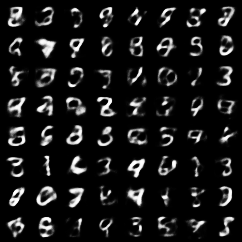



Train Epoch: 6 [0/60000 (0%)]	Loss: 110.809464
Train Epoch: 6 [12800/60000 (21%)]	Loss: 108.387131
Train Epoch: 6 [25600/60000 (43%)]	Loss: 107.663254
Train Epoch: 6 [38400/60000 (64%)]	Loss: 109.025284
Train Epoch: 6 [51200/60000 (85%)]	Loss: 106.448410
====> Epoch: 6 Average train loss: 108.5379
====> Epoch: 6 Average BCE loss: 83.6701
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


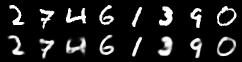

====> Test set loss: 107.5248
====> Test set BCE: 82.9483
Sample of generated images


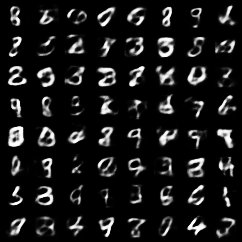



Train Epoch: 7 [0/60000 (0%)]	Loss: 109.120895
Train Epoch: 7 [12800/60000 (21%)]	Loss: 108.513084
Train Epoch: 7 [25600/60000 (43%)]	Loss: 109.951569
Train Epoch: 7 [38400/60000 (64%)]	Loss: 110.159386
Train Epoch: 7 [51200/60000 (85%)]	Loss: 108.108490
====> Epoch: 7 Average train loss: 107.7233
====> Epoch: 7 Average BCE loss: 82.7174
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


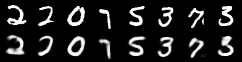

====> Test set loss: 106.8359
====> Test set BCE: 82.0427
Sample of generated images


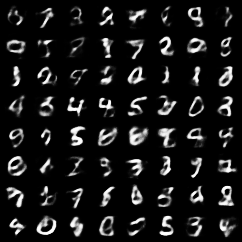



Train Epoch: 8 [0/60000 (0%)]	Loss: 104.248108
Train Epoch: 8 [12800/60000 (21%)]	Loss: 108.288010
Train Epoch: 8 [25600/60000 (43%)]	Loss: 103.374153
Train Epoch: 8 [38400/60000 (64%)]	Loss: 107.135742
Train Epoch: 8 [51200/60000 (85%)]	Loss: 108.874619
====> Epoch: 8 Average train loss: 107.0951
====> Epoch: 8 Average BCE loss: 82.0292
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


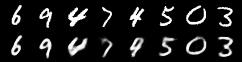

====> Test set loss: 106.4285
====> Test set BCE: 81.1880
Sample of generated images


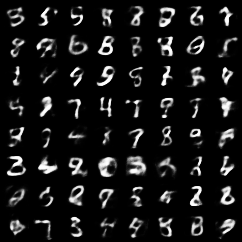



Train Epoch: 9 [0/60000 (0%)]	Loss: 104.386635
Train Epoch: 9 [12800/60000 (21%)]	Loss: 109.424232
Train Epoch: 9 [25600/60000 (43%)]	Loss: 104.132797
Train Epoch: 9 [38400/60000 (64%)]	Loss: 105.411880
Train Epoch: 9 [51200/60000 (85%)]	Loss: 107.894440
====> Epoch: 9 Average train loss: 106.6340
====> Epoch: 9 Average BCE loss: 81.4533
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


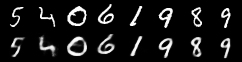

====> Test set loss: 105.8327
====> Test set BCE: 81.2054
Sample of generated images


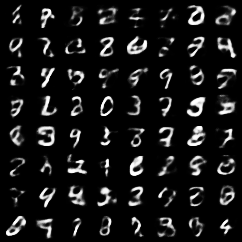



Train Epoch: 10 [0/60000 (0%)]	Loss: 105.021774
Train Epoch: 10 [12800/60000 (21%)]	Loss: 106.308212
Train Epoch: 10 [25600/60000 (43%)]	Loss: 107.586807
Train Epoch: 10 [38400/60000 (64%)]	Loss: 107.616364
Train Epoch: 10 [51200/60000 (85%)]	Loss: 106.739166
====> Epoch: 10 Average train loss: 106.1698
====> Epoch: 10 Average BCE loss: 81.0006
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


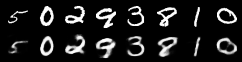

====> Test set loss: 105.5165
====> Test set BCE: 80.4791
Sample of generated images


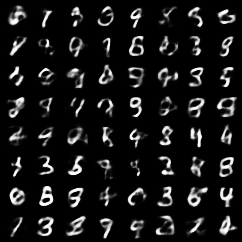

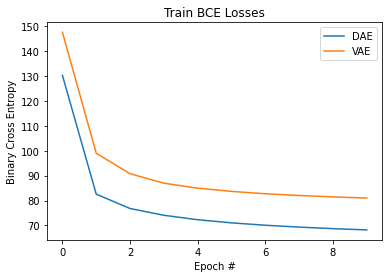

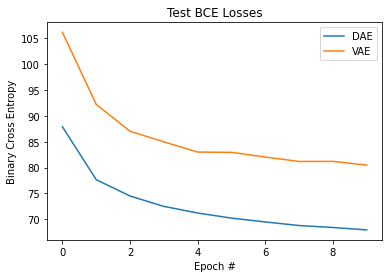

In [ ]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Discussion

The DAEs produce better reconstructed images and a lower reconstruction loss than the VAEs.  In contrast, the VAEs do not reconstruct images as well (and the reconstruction loss is higher), but they generate better images.  This is due to the fact that the VAE introduces a sampling step (followed by the reparameterization trick) that ensures that samples from  standard Gaussian N(0,1) are close to embeddings of real images.  In contrast, the DAEs embed images into a hidden space that could be anywhere and may not have much overlap with the region where the  standard Gaussian N(0,1) has most of its mass.  Hence,  when we sample from a standard Gaussian, the resulting embeddings may be far from those of the real images and as a result the decoder will produce images that often do not resemble digits.  It is normal for the VAE to have a higher reconstruction loss than the DAE since there is an additonal KL-divergence term that competes with the reconstruction loss.  This additional term can be thought as a regularizer that ensures that the embeddings are close to the high density region of the standard Gaussian. 